In [104]:
import random
import math
import copy
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
random.seed(123)
# Funkcja zwracająca koszt dla danego rozwiązania
def oblicz_koszt(rozwiazanie, odleglosc):
    # Zwracamy sumę odległości między kolejnymi miastami w rozwiązaniu
    koszt = 0
    for i in range(len(rozwiazanie) - 1):
        koszt += odleglosc[rozwiazanie[i]][rozwiazanie[i + 1]]
    # Dodajemy koszt drogi powrotnej do pierwszego miasta
    koszt += odleglosc[rozwiazanie[-1]][rozwiazanie[0]]
    return koszt

# Funkcja generująca słownik funkcji określającej
# Prawdopodobieństwo przyjęcia kandydata
# Słownik ma postać {funkcja: lista_parametrów}
def metropolis_probability(delta_e, temperature, prob_parameter=None):
    return min(1, math.exp(-delta_e / temperature))

def boltzmann_probability(delta_e, temperature, prob_parameter=None):
        return math.exp(-delta_e / temperature)

def gaussian_probability(delta_e, temperature, prob_parameter=3): # z sigmami chyba można mocno kombinować
    return math.exp(-(delta_e ** 2) / (2 * (prob_parameter ** 2) * temperature))

def exponential_decrease_probability(delta_e, temperature, prob_parameter=1): #alpha
        return math.exp(-prob_parameter * delta_e / temperature)


def power_law_probability(delta_e, temperature, prob_parameter): # decay_factor raczej jakiś taki okolo 2
        return 1 / ((delta_e + 1) ** prob_parameter * temperature)
def prob_functions_dict():



    

    
    # def sigmoid_probability(delta_e, temperature, prob_parameter):
    #     return 1 / (1 + math.exp(-prob_parameter * delta_e / temperature)) #sigmoid

   

    

    decay_factors = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6]

    sigma_factors = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3]

    alpha_factors = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    # sigmoid_parameters = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    return {metropolis_probability: [None], boltzmann_probability: [None],
            exponential_decrease_probability: alpha_factors,
            gaussian_probability: sigma_factors, power_law_probability: decay_factors}

# Funkcja generująca słownik funkcji określającej
# Zmianę temperatury wraz z działaniem algorytmu
# Słownik ma postać {funkcja: lista_parametrów}
def t_decrease_functions_dict():



    # def exponential_cooling(T_init, T, iteration, cool_parameter):  # około 0.05
    #     return T_init * math.exp(-cool_parameter * iteration)

    linear_parameters = [0.9999, 0.99999, 0.999999, 0.9999999]

    #exp_parameters = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

    return {
        #exponential_cooling: exp_parameters,
        linear_decrease: linear_parameters
            }

# Funkcja czytająca format .atsp
# Zwraca macierz sąsiedztwa
def read_atsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

        # Extract the dimension of the problem
        for line in lines:
            if line.startswith('DIMENSION'):
                n = int(line.strip().split()[1])
                break

        # Extract the matrix
        matrix = []
        row = []
        start_reading = False
        for line in lines:
            if line.startswith('EDGE_WEIGHT_SECTION'):
                start_reading = True
                continue
            if start_reading:
                lista_liczb = list(map(int, line.strip().split()))
                for i in lista_liczb:
                    row.append(i)
                    if len(row) == n:
                        matrix.append(row)
                        row = []
                if len(matrix) == n:
                    break
        for i in range(len(matrix)):
            matrix[i][i]= 1000000

    return matrix

def simulated_annealing(T_init, T_function, cool_parameter,
                        Prob_function, prob_parameter,
                        break_point, file_name):
    

    odleglosc = read_atsp_file(file_name)
    miasta = [i for i in range(len(odleglosc))]

    liczba_iteracji = 1000000  # liczba iteracji

    # Losujemy początkowe rozwiązanie
    S = random.sample(range(len(miasta)), len(miasta))

    # Pętla główna algorytmu
    C1, C2 = 0, 0
    T = T_init

    global_min = float('inf')
    global_min_path = []

    list_of_costs=[i for i in range(100)]

    for i in range(liczba_iteracji):

        # Losujemy dwa miasta i zamieniamy je miejscami
        S_p = S.copy()
        a = random.randint(0, len(S_p) - 1)
        b = random.randint(0, len(S_p) - 1)
        S_p[a], S_p[b] = S_p[b], S_p[a]

        # Obliczamy koszty dla obu rozwiązań
        C1 = oblicz_koszt(S, odleglosc)
        C2 = oblicz_koszt(S_p, odleglosc)

        # Sprawdzamy czy akceptujemy nowe rozwiązanie
        if C2 < C1:
            S = S_p
        else:
            delta_e = abs(C1-C2)
            p = Prob_function(delta_e, T, prob_parameter)
            if random.random() < p:
                S = S_p

        if i % 10000 == 0:
            print(min(C1, C2))
            #tu zmienione, zeby tworzylo liste kosztow
            list_of_costs[i//10000]=global_min


            print(T)

        # Zmniejszamy temperaturę
        T = T_function(T_init, T, i, cool_parameter)
        if T < break_point:
            break
        if oblicz_koszt(S, odleglosc) < global_min:
            global_min_path = [miasta[i] for i in S]
            global_min = oblicz_koszt(S, odleglosc)

    # Zwracamy najlepsze znalezione rozwiązanie
    najlepsze_rozwiazanie = [miasta[i] for i in S]
    end = time.time()

    return global_min_path, global_min,  list_of_costs
    # Sciezka, koszt, lista kosztów- NOWE

def linear_decrease(Top_T, T, iteration, cool_parameter):
    return T * cool_parameter

def main():

    prob_dict = []
    temp_dict = t_decrease_functions_dict()

    starting_temperatures = [50000]  # Lista temperatur początkowych

    file_names = ['data/ftv170.atsp']  # Lista nazw plików

    min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

    df = pd.DataFrame(columns=['file_name', 'prob_function', 'prob_parameter', 'temp_function',
                               'cool_parameter', 'T_init', 'function_result', 'time', 'path'])

    

In [105]:
#PARAMETR CHLODZENIA
dict={}
starting_temperatures = [50000] 
file = 'data/ftv33.atsp'  

min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

linear_parameters = [0.999, 0.9999, 0.99999]
dict= {k: [] for k in linear_parameters}
for parametr in linear_parameters:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                            cool_parameter=parametr,
                                                            Prob_function=gaussian_probability, prob_parameter=3,
                                                            break_point=min_temperature, file_name=file)
        dict[parametr].append(function_result)

print(dict)

4515
30000
1876
1.355200379311442
4205
30000
1746
1.355200379311442
4211
30000
1697
1.355200379311442
4672
30000
1620
1.355200379311442
4914
30000
1700
1.355200379311442
4444
30000
1726
1.355200379311442
4338
30000
1577
1.355200379311442
3960
30000
1564
1.355200379311442
4310
30000
1644
1.355200379311442
4523
30000
1738
1.355200379311442
4392
30000
4218
11035.831392989121
3833
4059.652484482816
4118
1493.3880110960613
3133
549.359276492254
2580
202.08787831809946
1789
74.34025838951453
1698
27.346885243264293
1456
10.059853822269574
1456
3.700628354022838
1456
1.361317018770361
1456
0.5007755030518772
1456
0.1842158005806604
4214
30000
4286
11035.831392989121
4158
4059.652484482816
3965
1493.3880110960613
3418
549.359276492254
2663
202.08787831809946
1871
74.34025838951453
1543
27.346885243264293
1489
10.059853822269574
1489
3.700628354022838
1491
1.361317018770361
1487
0.5007755030518772
1489
0.1842158005806604
4191
30000
4092
11035.831392989121
3621
4059.652484482816
3813
1493.388011

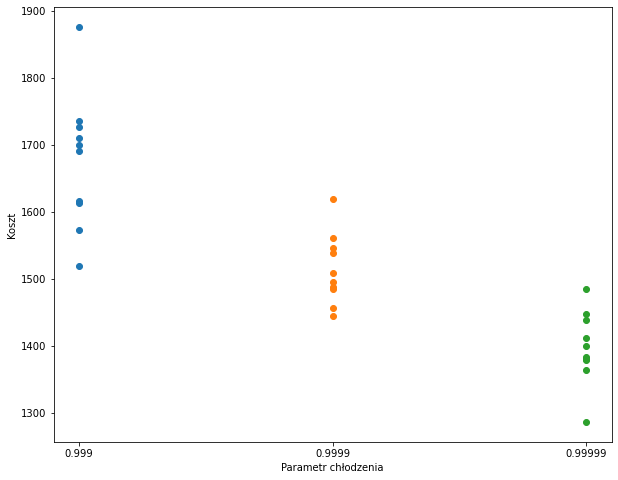

In [106]:
#wykres do parametrów chłodzenia
linear_parameters = [0.999, 0.9999, 0.99999]
plt.figure(figsize=(10,8))
plt.xlabel("Parametr chłodzenia")
plt.ylabel("Koszt")
for param in linear_parameters:
    
    plt.scatter([str(param)]*len(dict[param]), dict[param], label=param)


In [107]:
#TEMPERATURA CHŁODZENIA
dict={}
starting_temperatures = [50000, 30000, 15000, 5000]  

dict= {k: [] for k in starting_temperatures}
for temp in starting_temperatures:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=temp, T_function=linear_decrease,
                                                            cool_parameter=0.99999,
                                                            Prob_function=metropolis_probability, prob_parameter=None,
                                                            break_point=min_temperature, file_name=file)
        dict[temp].append(function_result)


print(dict)


4431
50000
4332
45241.84828073822
4731
40936.49671714646
4271
37040.855472441435
4054
33515.93526945876
4101
30326.457168957575
3829
27440.49948260569
4454
24829.17828679442
4262
22466.358339730956
4383
20328.391508535922
4121
18393.880088412403
4195
16643.46264508081
3863
15059.620237097522
3924
13626.501078645812
4519
12329.76188794805
4285
11156.42433344343
4548
10094.745140983661
4567
9134.098562021994
4704
8264.87002648607
4462
7478.359915965986
4343
6766.696494137669
3806
6122.757122991548
3960
5540.096976363819
4194
5012.884537304537
4180
4535.843233711723
4526
4104.198628095965
4542
3713.630632926601
4507
3360.2302733113133
4080
3040.460564269859
4047
2751.121111045279
4495
2489.316078156915
4542
2252.4252066155277
4054
2038.0775892281993
4052
1844.1279415246902
4355
1668.6351308146016
4424
1509.8427484844565
3585
1366.1615310941168
4834
1236.1534543348046
4434
1118.517340654501
3592
1012.0758365053092
4329
915.7636288754844
4800
828.6167831720537
3826
749.7630957428614
3994
67

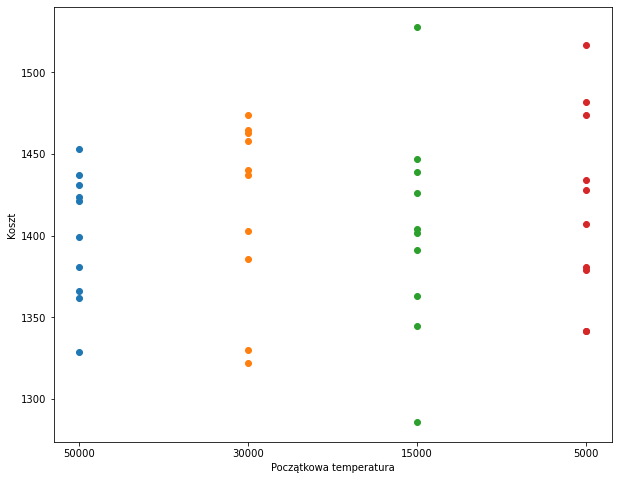

In [108]:
#wykres dla poczatkowych temperatur

plt.figure(figsize=(10,8))
plt.xlabel("Początkowa temperatura")
plt.ylabel("Koszt")
for temp in starting_temperatures:
    plt.scatter([str(temp)]*len(dict[temp]), dict[temp], label=temp)


In [109]:
dict={}


parametry=[None, None,1, 3, 2 ]

prob_functions=[metropolis_probability, boltzmann_probability, exponential_decrease_probability, gaussian_probability,power_law_probability]

dict= {k: [] for k in prob_functions}
i=0
for fun in prob_functions:
    prob_parameter=parametry[i]
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                            cool_parameter=0.99999,
                                                            Prob_function=fun, prob_parameter=parametry[i],
                                                            break_point=min_temperature, file_name=file)
        dict[fun].append(function_result)
    i+=1


#print(dict)

4460
30000
4526
27145.108968442815
4063
24561.898030287775
4403
22224.51328346469
4208
20109.561161674956
3929
18195.87430137439
4525
16464.299689563148
4369
14897.506972076413
4083
13479.815003838414
4237
12197.034905121465
4869
11036.328053047337
4216
9986.07758704842
4376
9035.772142258456
4468
8175.90064718754
4384
7397.85713276891
3940
6693.854600066125
4034
6056.8470845902075
4628
5480.45913721323
4459
4958.9220158917
4499
4487.015949579671
4252
4060.0178964827446
4276
3673.654273795092
4238
3324.058185818434
4428
3007.730722382845
4208
2721.5059402271736
4335
2462.5191768576765
4403
2228.178379756045
4190
2016.1381639868782
4754
1824.2763385620092
4641
1650.6726666272505
3981
1493.5896468942155
4595
1351.4551239693835
4286
1222.846553536975
3810
1106.4767649148614
3790
1001.1810784888055
4108
905.9056490907207
3908
819.69691865652
4020
741.6920726009297
4521
671.1104043927501
4089
607.2455019032283
3925
549.4581773253279
4069
497.1700699032623
4380
449.85785744574423
3743
407.04

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

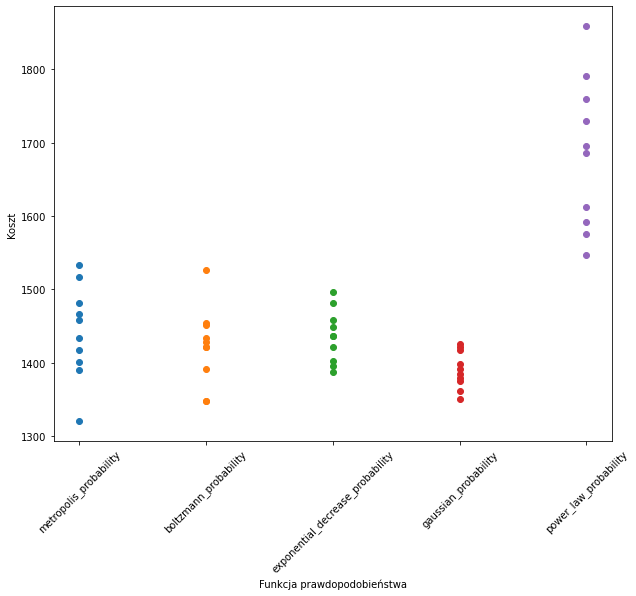

In [110]:
plt.figure(figsize=(10,8))
plt.xlabel("Funkcja prawdopodobieństwa")
plt.ylabel("Koszt")
for fun in prob_functions:
    plt.scatter([str(fun.__name__)]*len(dict[fun]), dict[fun], label=fun)
 
plt.xticks(rotation=45)


In [111]:
#wykres zaleznosci kosztu od iteracji
dict={}
dict= {k: [] for k in range(10)}
for i in range(10):
    path, function_result, list_of_costs = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                        cool_parameter=0.99999,
                                                        Prob_function=metropolis_probability, prob_parameter=None,
                                                        break_point=0.1, file_name=file)
    dict[i].append(list_of_costs)
x=list(range(0,1000000,10000))



4162
30000
3362
27145.108968442815
4550
24561.898030287775
4261
22224.51328346469
4413
20109.561161674956
4662
18195.87430137439
4374
16464.299689563148
4111
14897.506972076413
3883
13479.815003838414
3912
12197.034905121465
4797
11036.328053047337
3793
9986.07758704842
4092
9035.772142258456
4454
8175.90064718754
4254
7397.85713276891
4355
6693.854600066125
4263
6056.8470845902075
4397
5480.45913721323
4048
4958.9220158917
4902
4487.015949579671
3892
4060.0178964827446
4085
3673.654273795092
4353
3324.058185818434
4520
3007.730722382845
4239
2721.5059402271736
4423
2462.5191768576765
4441
2228.178379756045
4524
2016.1381639868782
4012
1824.2763385620092
3592
1650.6726666272505
4198
1493.5896468942155
4133
1351.4551239693835
3913
1222.846553536975
4614
1106.4767649148614
4218
1001.1810784888055
4114
905.9056490907207
4754
819.69691865652
4140
741.6920726009297
3702
671.1104043927501
4713
607.2455019032283
4025
549.4581773253279
4170
497.1700699032623
4128
449.85785744574423
4577
407.04

In [114]:
mean_cost=[0]*100
suma=0
for i in range(len(list_of_costs)):
    for k in range(10):
        suma+= dict[k][0][i]
    mean_cost[i]=suma/10
    suma=0

mean_cost

[inf,
 3329.2,
 3255.4,
 3243.9,
 3217.9,
 3217.9,
 3214.1,
 3177.7,
 3169.1,
 3166.9,
 3166.2,
 3159.7,
 3147.7,
 3147.7,
 3147.7,
 3138.1,
 3138.1,
 3138.1,
 3132.2,
 3124.3,
 3119.9,
 3086.0,
 3086.0,
 3086.0,
 3081.6,
 3081.6,
 3081.6,
 3081.6,
 3078.3,
 3078.3,
 3064.2,
 3064.2,
 3062.9,
 3049.4,
 3047.6,
 3047.6,
 3044.6,
 3044.6,
 3044.6,
 3044.6,
 3044.6,
 3044.6,
 3038.1,
 3030.2,
 3028.3,
 3012.4,
 3008.8,
 3008.8,
 2989.0,
 2951.6,
 2949.1,
 2911.4,
 2895.1,
 2851.4,
 2805.6,
 2758.7,
 2717.7,
 2696.5,
 2638.0,
 2570.1,
 2533.7,
 2460.3,
 2339.1,
 2240.5,
 2217.1,
 2093.7,
 1997.8,
 1966.7,
 1921.8,
 1810.3,
 1709.8,
 1653.9,
 1618.8,
 1568.2,
 1491.6,
 1484.4,
 1461.9,
 1454.8,
 1436.8,
 1429.5,
 1427.8,
 1427.4,
 1425.8,
 1420.2,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0,
 1420.0]

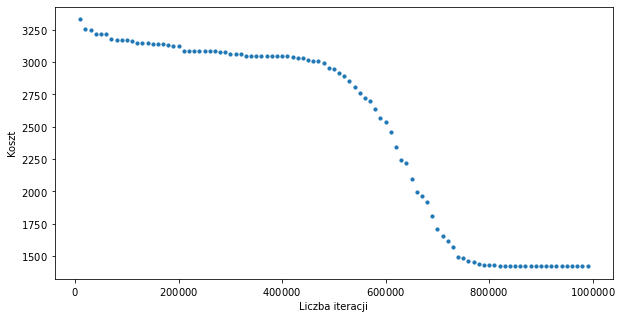

In [115]:

plt.figure(figsize=(10,5))
plt.scatter(x,mean_cost, s=10)
plt.xlabel("Liczba iteracji")
plt.ylabel("Koszt")
plt.ticklabel_format(style='plain', axis='both')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().get_xaxis().set_major_formatter(formatter)
plt.gca().get_yaxis().set_major_formatter(formatter)


